<a href="https://colab.research.google.com/github/yueop/AS_LAB/blob/main/compare_mnist_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import sys
from google.colab import drive

# 1. 드라이브 마운트
drive.mount('/content/drive')

# 2. 경로 설정
PROJECT_PATH = '/content/drive/MyDrive/AS_LAB'
if not os.path.exists(PROJECT_PATH):
    os.makedirs(PROJECT_PATH)

# 3. 시스템 경로 추가 및 작업 디렉토리 변경
if PROJECT_PATH not in sys.path:
    sys.path.append(PROJECT_PATH)
os.chdir(PROJECT_PATH)

print(f"현재 위치: {os.getcwd()}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
현재 위치: /content/drive/MyDrive/AS_LAB


최고 성능 모델 로드 완료
MLP가 틀린 문제 수집중
오분류 이미지 수집 완료
분석 시작
총 샘플 수: 20


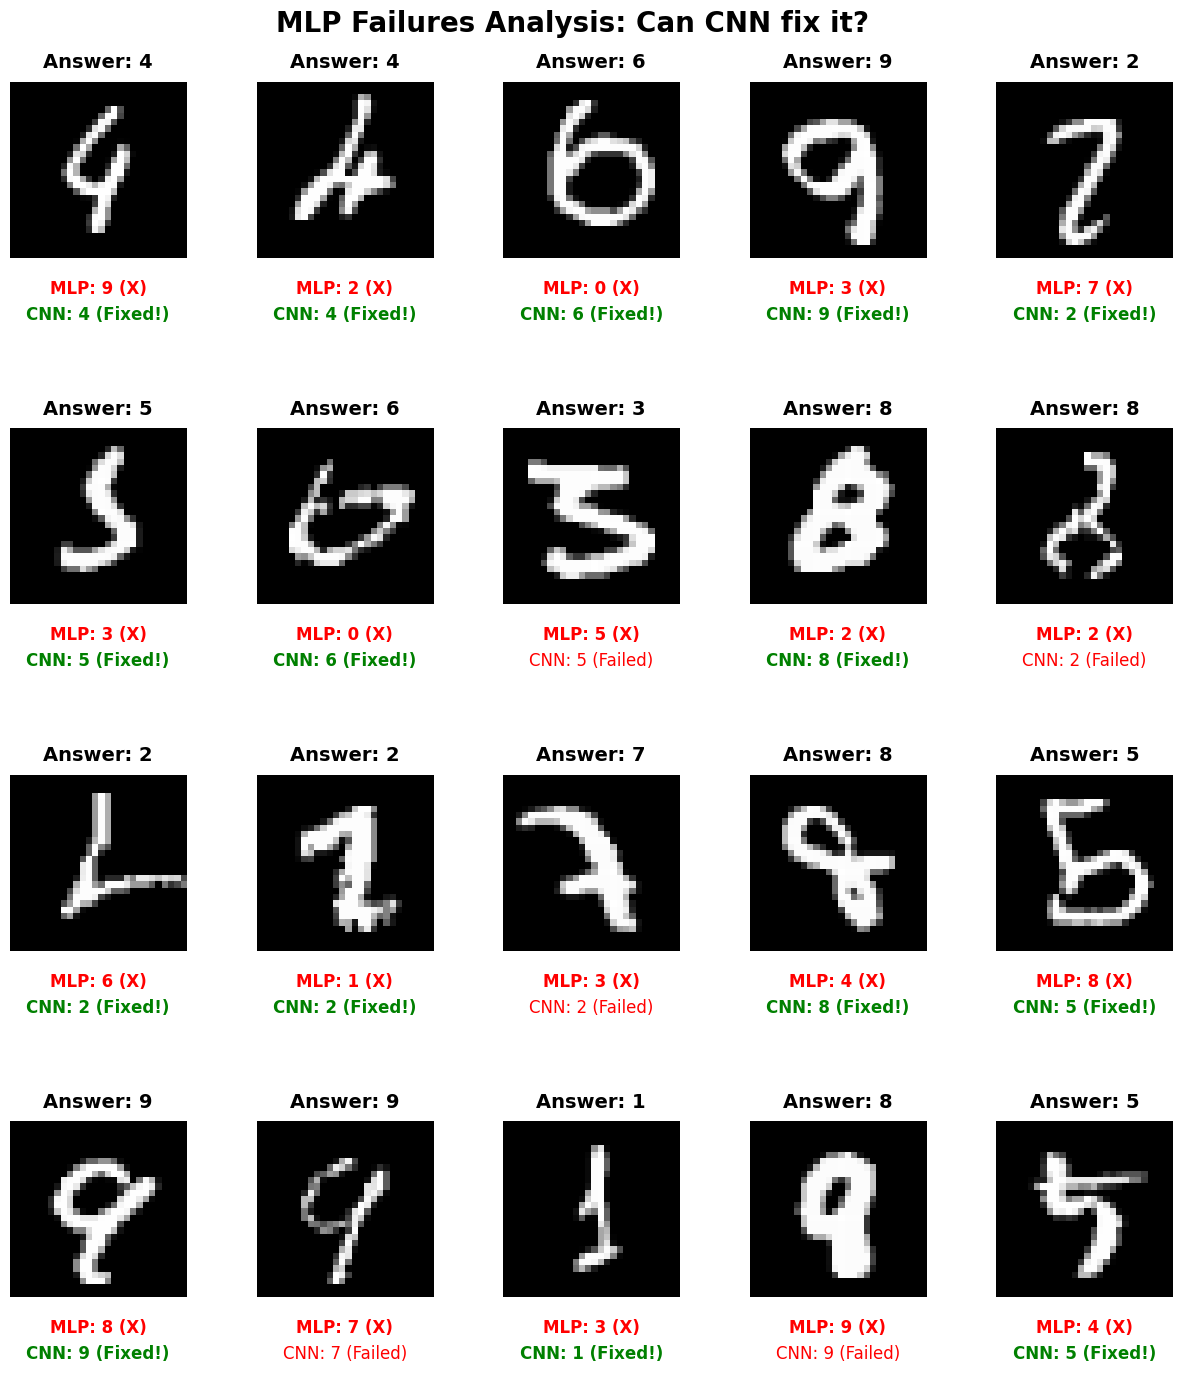

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
import random

from models import MLP, CNN
from my_datasets import UnifiedDataLoader

FILE_NAME = 'config_mnist_cnn.yaml'
SAVE_PATH = f"/content/drive/MyDrive/AS_LAB/{FILE_NAME}"

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True # 연산 속도는 느려지지만 결과는 무조건 고정
    torch.backends.cudnn.benchmark = False

seed_everything(42)

#1. 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#데이터 로더 설정값
cfg = {
    'data': {
        'batch_size': 1000,
        'split_ratio': 0.2,
        'augmentation': {'use_aug': False}
    },
    'train': {'seed': 42}
}

#2. 데이터 및 모델 준비
data_loader = UnifiedDataLoader(cfg)
test_loader = data_loader.get_loader('mnist', mode='test')

mlp_path = 'best_mnist_mlp.pth'
cnn_path = 'best_mnist_cnn.pth'

try:
    mlp_model = MLP(input_size=784, hidden_size=256, num_classes=10).to(device)
    mlp_model.load_state_dict(torch.load(mlp_path, map_location=device))
    mlp_model.eval()

    cnn_model = CNN(num_classes=10).to(device)
    cnn_model.load_state_dict(torch.load(cnn_path, map_location=device))
    cnn_model.eval()
    print("최고 성능 모델 로드 완료")
except Exception as e:
    print(f"모델 로드 실패 {e}")

#3. 비교분석
def find_mlp_failures(loader, mlp, cnn, count=20):
    failure_samples = [] #(이미지, 정답, MLP 예측, CNN 예측)

    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)

            pred_mlp = mlp(data).argmax(dim=1, keepdim=True)
            pred_cnn = cnn(data).argmax(dim=1, keepdim=True)

            for i in range(len(data)):
                #MLP가 틀린 데이터 수집
                if pred_mlp[i].item() != target[i].item():
                    failure_samples.append((
                        data[i].cpu(),
                        target[i].item(),
                        pred_mlp[i].item(),
                        pred_cnn[i].item()
                    ))

                if len(failure_samples) >= count:
                    return failure_samples
    return failure_samples

print("MLP가 틀린 문제 수집중")
samples = find_mlp_failures(test_loader, mlp_model, cnn_model, count=20)
print("오분류 이미지 수집 완료")

#4. 시각화(CNN 정답 여부)
if mlp_model is not None and cnn_model is not None:
    print("분석 시작")
    samples = find_mlp_failures(test_loader, mlp_model, cnn_model, count=20)
    print(f"총 샘플 수: {len(samples)}")

    if 'samples' in locals() and len(samples) > 0:
        # 1. 그림 판을 더 길게 설정 (세로 길이 14 -> 16)
        fig = plt.figure(figsize=(15, 16))

        # 제목 설정
        fig.suptitle(f"MLP Failures Analysis: Can CNN fix it?", fontsize=20, y=0.92, fontweight='bold')

        # 2. 이미지 사이의 간격 조절 (핵심! hspace를 0.8로 줘서 위아래 간격을 넓힘)
        plt.subplots_adjust(wspace=0.4, hspace=0.8)

        for idx, (img, label, mlp_wrong, cnn_pred) in enumerate(samples):
            ax = fig.add_subplot(4, 5, idx+1)

            img_np = img.squeeze().numpy()
            ax.imshow(img_np, cmap='gray')

            # 정답 (이미지 바로 위)
            ax.set_title(f"Answer: {label}", fontsize=14, fontweight='bold', pad=10)

            # 3. 텍스트 위치 및 크기 조정
            # MLP 결과 (빨강)
            ax.text(0.5, -0.2, f"MLP: {mlp_wrong} (X)",
                    color='red', ha='center', transform=ax.transAxes,
                    fontsize=12, fontweight='bold')

            # CNN 결과 (초록/빨강)
            if cnn_pred == label:
                cnn_text = f"CNN: {cnn_pred} (Fixed!)" # 정답!
                cnn_color = 'green'
                weight = 'bold'
            else:
                cnn_text = f"CNN: {cnn_pred} (Failed)" # 같이 틀림
                cnn_color = 'red'
                weight = 'normal'

            ax.text(0.5, -0.35, cnn_text,
                    color=cnn_color, ha='center', transform=ax.transAxes,
                    fontsize=12, fontweight=weight)

            ax.axis('off')

        #이미지 파일로 저장
        save_file_path = os.path.join('mlp_vs_cnn_result.png')
        plt.savefig(save_file_path, bbox_inches='tight', dpi=300) #bbox_inches: 여백 지우기, dpi: 화질(300이면 인쇄품질)

        plt.show()